# Условие
Вычислить определённый интеграл $\int\limits_{a}^{b} f(x)p(x) \ dx $, где $$16. \space f(x) = 2.7 \cos(3.5x)\exp(-7x/3) + 4.4\sin(2.5x)\exp(5x/3)+2$$
$$p(x) = (b-x)^{-\beta}$$
$a = 2.8, \space b=4.3, \alpha = 0, \beta = \frac{3}{7}$ 

Сделаем замену: $t = b - x$
$$ \hat{f} (t) = f(b-t) = 2.7 \cos(3.5 \cdot (b-t)) \exp(-7(b-t)/3) + 4.4 \sin (2.5 \cdot (b-t)) \exp(5\cdot(b-t)/3) + 2  $$

# Код

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prettytable
import pandas as pd
import warnings
from functools import lru_cache
import math
from tqdm import tqdm
warnings.filterwarnings('ignore')
from scipy.stats import linregress

In [29]:
true_value_integral =  -3246.875926327328894367882485073567528036
a = 2.8
b = 4.3
beta = 3/7
rtol = 10**(-10)

# Вариант Ньютона-Котса

Общая формула для вычисления моментов. <br>
$$ \mu_s = \int\limits_{a}^{b}x^s p(x) dx$$
Преобразуем для нашего случая.
$$ \int\limits_{a}^{b}f(x)p(x)dx = \int\limits_{b-a}^{0}f(b-t)t^{-\beta} d(b - t) = \int\limits_{0}^{b-a}\hat f(t)t^{-\beta}dt$$
$$ \mu_s = \int\limits_{0}^{b-a}\frac{t^s}{t^\beta}dt$$

$$\mu_0 = (-\beta+1)^{-1}\cdot (t)^{-\beta + 1}\Bigg|_{0}^{b-a} = $$
$$\mu_1 = (2-\beta)^{-1}\cdot (t)^{2-\beta}\Bigg|_{0}^{b-a}$$
$$ \ldots$$
$$ \mu_5 = (6-\beta)^{-1}\cdot (t)^{6 - \beta}\Bigg|_{0}^{b-a}$$

In [8]:
# @lru_cache
def moment(a, b, beta): ## Замена сделана
    result = []
    for i in range(6):
        temp = (1+i-beta)**(-1) * (b ** (1+i-beta) - a **(1+i-beta))
        result.append(temp)
    return result

In [9]:
# @lru_cache
def coef_for_IQF_N (a, b, beta, nodes):
    nodes = np.expand_dims(np.array(nodes), axis=0)
    matr = np.concatenate((nodes**0, nodes**1, nodes**2))
    mu = moment(a, b, beta)
    result = np.linalg.solve(matr, mu[:3])
    return result


In [10]:
# @lru_cache
def hat_f(t):
    x = 4.3 - t
    y = 2.7 * np.cos(3.5*x)*np.exp(-7*x/3) + 4.4*np.sin(2.5*x)*np.exp(5*x/3)+2
    return y

## Вычисление трёхточечной ИКФ

Вычисление моментов $\mu_j = \int\limits_{a}^{b}p(x)x^j dx$

In [30]:
h_c = abs(b - a)
eps = 10**(-6)
N = 1
R = np.inf
S_up = np.nan
p = np.nan
p_up = np.nan
p_r = np.nan
L = 2
m = 4
E = np.inf
# Rid_e = np.inf
ans = pd.DataFrame(columns=['N','h', 'S', 'E', 'R', 'S_up', 'p', 'p_up', 'p_r', ])

In [8]:
while (abs(R) > rtol):
    nodes = np.linspace(0, b-a, N + 1)
    h = h_c / N
    S = 0
    for i in tqdm(range(len(nodes) - 1)):
        temp_nodes = np.linspace(nodes[i], nodes[i+1], 3)
        coef = coef_for_IQF_N(nodes[i], nodes[i+1], beta, temp_nodes)
        S += coef[0] * hat_f(temp_nodes[0]) + coef[1] * hat_f(temp_nodes[1]) + coef[2] * hat_f(temp_nodes[2])
    E = abs(S - true_value_integral)/ abs(S)
    if N >= 2:
        R = (S - ans.iloc[-1]['S'])/(L**m - 1)
        S_up = S + R
        R /= abs(S)
    if N >= 4:
            p = -np.log(abs(S - ans.iloc[-1]['S']) / abs(ans.iloc[-1]['S'] - ans.iloc[len(ans)-2]['S'])) / np.log(L)
            p_up = -np.log(abs(S_up - ans.iloc[-1]['S_up']) / abs(ans.iloc[-1]['S_up'] - ans.iloc[len(ans)-2]['S_up'])) / np.log(L)
            p_r = np.log10(abs(R)) / np.log10(h)
            
    ans = pd.concat([ans, pd.DataFrame([[N, h, S, E, R, S_up, p, p_up, p_r]], 
                                        columns=['N', 'h', 'S', 'E', 'R', 'S_up', 'p', 'p_up', 'p_r'])],
                     ignore_index=True)
    N = N * 2
    
        

100%|██████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 8314.59it/s]


In [9]:
ans

,N,h,S,E,R,S_up,p,p_up,p_r
0,1,1.500000,-3188.658988,1.825750e-02,inf,NaN,NaN,NaN,NaN
1,2,0.750000,-3196.730945,1.568633e-02,-1.683377e-04,-3197.269076,NaN,NaN,NaN
2,4,0.375000,-3239.445550,2.293719e-03,-8.790518e-04,-3242.293190,-2.403739,NaN,7.174202
3,8,0.187500,-3246.047168,2.553132e-04,-1.355827e-04,-3246.487276,2.693838,3.424270,5.320223
4,16,0.093750,-3246.793901,2.526347e-05,-1.533273e-05,-3246.843683,3.144155,3.556756,4.683119
5,32,0.046875,-3246.868286,2.353198e-06,-1.527313e-06,-3246.873245,3.327514,3.591736,4.376084
6,64,0.023438,-3246.875239,2.117743e-07,-1.427613e-07,-3246.875702,3.419316,3.588477,4.199397
7,128,0.011719,-3246.875866,1.865928e-08,-1.287433e-08,-3246.875908,3.471035,3.581411,4.085857
8,256,0.005859,-3246.875921,1.621597e-09,-1.135846e-09,-3246.875925,3.502658,3.576717,4.007206
9,512,0.002930,-3246.875926,1.396208e-10,-9.879843e-11,-3246.875926,3.523135,3.574129,3.949682


### Вычисление h_opt

In [10]:
R_h = ans.R[4]
m_opt = ans.p[4]
h_opt = 0.95*(ans.h[4]) * (rtol/abs(R_h))**(1/m_opt)
temp_step =(b - a)/h_opt
N_opt = 2**(math.ceil(np.log2(temp_step)))
N_opt, temp_step
S_pred=0 

In [11]:
for j in range(1,3):
    nodes = np.linspace(0, b-a, int(N_opt*j/2) + 1)
    h = h_c / N_opt
    S = 0
    for i in tqdm(range(len(nodes) - 1)):
        temp_nodes = np.linspace(nodes[i], nodes[i+1], 3)
        coef = coef_for_IQF_N(nodes[i], nodes[i+1], beta, temp_nodes)
        S += coef[0] * hat_f(temp_nodes[0]) + coef[1] * hat_f(temp_nodes[1]) + coef[2] * hat_f(temp_nodes[2])
    # E = abs(S - true_value_integral)/ abs(S)
    if N_opt*j > N_opt:
        R = (S - S_pred)/(L**m_opt - 1)
        S_up = S + R
        R /= abs(S)
    else:
        S_pred = S
        # print(1)

100%|████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 8075.33it/s]


In [12]:
print(R)
print(abs(R) < rtol)
print(S,S_pred)

-1.6284076648553953e-11
True
-3246.875926288552 -3246.8759258739974


In [13]:
h_opt

0.001997128067984639

In [15]:
R_h = (temp_value_integral[1] - temp_value_integral[0])/(2**4-1)/S
h_opt = 0.95*(temp_nodes_2[1] - temp_nodes_2[0]) * (rtol/abs(R_h))**0.25
temp_step =(b - a)/h_opt
N_opt = 2**(math.ceil(np.log2(temp_step)))
N_opt, temp_step

NameError: name 'temp_value_integral' is not defined

### Недоделанный график

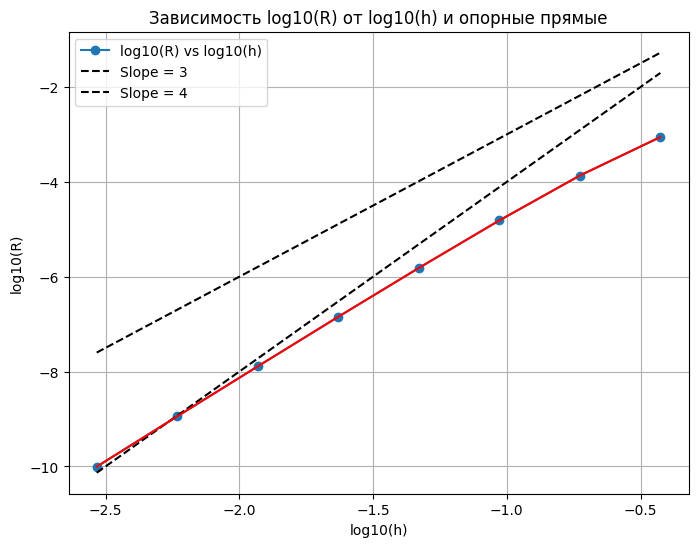

In [16]:
# Пример данных (замените ans на ваш DataFrame)
# ans = pd.DataFrame({'N': ..., 'h': ..., 'S': ..., 'E': ..., 'R': ..., 'S_up': ..., 'p': ..., 'p_up': ..., 'p_r': ...})

# Фильтруем данные, чтобы убрать строки с np.inf или np.nan в столбце 'R'
ans_filtered = ans.dropna(subset=['p_r']).loc[~ans['p_r'].isin([np.inf, -np.inf])]

# Вычисляем логарифмы значений
log_h = np.log10(ans_filtered['h'])
log_R = np.log10(np.abs(ans_filtered['R']))

# Построение графика зависимости log10(R) от log10(h)
plt.figure(figsize=(8, 6))
plt.plot(log_h, log_R, label='log10(R) vs log10(h)', marker='o')

# Добавляем опорные прямые с углом наклона 3 и 4
# Для этого создадим данные для прямых
min_log_h, max_log_h = log_h.min(), log_h.max()
log_h_line = np.linspace(min_log_h, max_log_h, 100)

# Прямая с углом наклона 3
plt.plot(log_h_line, log_h_line * 3, 'k--', label='Slope = 3')

# Прямая с углом наклона 4
plt.plot(log_h_line, log_h_line * 4 , 'k--', label='Slope = 4')

# Вычисление наклона регрессии для логарифмов
slope = log_R / log_h
# slope, intercept, _, _, _ = linregress(log_h, log_R)
plt.plot(log_h, slope * log_h, 'r-')

# Настройки графика
plt.xlabel('log10(h)')
plt.ylabel('log10(R)')
plt.title('Зависимость log10(R) от log10(h) и опорные прямые')
plt.legend()
plt.grid(True)
plt.show()

# Вывод наклона в таблицу
ans_filtered['p_r'] = slope

In [ ]:
q = np.array([1, 2, 3])
qq = np.array([2, 2, 3])

# Вариант Гаусса

In [6]:
def coef_for_nodal_pol (a, b, beta):  # np.array(), shape(result) = (3, )
    mu = moment(a, b, beta)
    mu = np.expand_dims(np.array(mu), axis=0)
    matr = np.concatenate((mu[:,:3], mu[:,1:4], mu[:,2:5]))
    result = np.linalg.solve(matr, -mu[0,3:])
    return result

In [7]:
def coef_for_IKF_G (a, b, beta):
    coef = coef_for_nodal_pol(a, b, beta)
    coef = np.append(coef, 1)
    mu = moment(a, b, beta)
    nodes = np.roots(coef[::-1])
    # print(nodes)
    for i in range(len(nodes)):

        if complex(nodes[i]).imag == 0:
            if nodes[i] < a:
                nodes[i] = a
            if nodes[i] > b:
                nodes[i] = b
        else:
             raise ValueError()
    nodes = np.expand_dims(nodes, axis = 0)
    matr = np.concatenate((nodes**0, nodes**1, nodes**2))
    result = np.linalg.solve(matr, mu[:3])
    return result, nodes
           

## Вычисление трёхточечной ИКФ 

In [31]:
h_c = abs(b - a)
eps = 10**(-6)
N = 1
R = np.inf
S_up = np.nan
p = np.nan
p_up = np.nan
p_r = np.nan
L = 2
m = 6
E = np.inf
p = m
# Rid_e = np.inf
ans_g = pd.DataFrame(columns=['N','h', 'S', 'E', 'R', 'S_up', 'p', 'p_up', 'p_r', ])

In [32]:

while (abs(R) > rtol):
    
    glob_interval = np.linspace(0, b-a, N + 1)
    h = h_c / N
    S = 0
    for i in tqdm(range(len(glob_interval) - 1)):
        # temp_nodes = np.linspace(glob_interval[i], glob_interval[i+1], 3)
        coef, temp_nodes = coef_for_IKF_G(glob_interval[i], glob_interval[i+1], beta)
        # print(coef, temp_nodes)
        S += coef[0] * hat_f(temp_nodes[:,0]) + coef[1] * hat_f(temp_nodes[:,1]) + coef[2] * hat_f(temp_nodes[:,2])
    E = abs(S - true_value_integral)/ abs(S)

    if N >= 2:
        R = (S - ans_g.iloc[-1]['S'])/(L**m - 1)
        S_up = S + R
        R /= abs(S)

    if N>= 4:
        p = -np.log(abs(S - ans_g.iloc[-1]['S']) / abs(ans_g.iloc[-1]['S'] - ans_g.iloc[-2]['S'])) / np.log(L)
        p_up = -np.log(abs(S_up - ans_g.iloc[-1]['S_up']) / abs(ans_g.iloc[-1]['S_up'] - ans_g.iloc[-2]['S_up'])) / np.log(L)
        p_r = np.log10(abs(R)) / np.log10(h)
    
    ans_g = pd.concat([ans_g, pd.DataFrame([[N, h, S, E, R, S_up, p, p_up, p_r]], 
                                        columns=['N', 'h', 'S', 'E', 'R', 'S_up', 'p', 'p_up', 'p_r'])],
                     ignore_index=True)
    N = N * 2
    

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1684.14it/s]


In [33]:
ans_g

,N,h,S,E,R,S_up,p,p_up,p_r
0,1,1.500000,[-3256.8273691498594],[0.003055563496178902],inf,NaN,6,NaN,NaN
1,2,0.750000,[-3246.8831756550785],[2.232703598388584e-06],[4.861411164112843e-05],[-3246.7253313138917],6,NaN,NaN
2,4,0.375000,[-3246.8748027267575],[3.460560198524294e-07],[4.093278374380551e-08],[-3246.8746698231334],[10.213906378829792],[nan],[17.343828688032104]
3,8,0.187500,[-3246.8759016335025],[7.60541114310032e-09],[-5.372230025182525e-09],[-3246.8759190764667],[2.929663312463209],[6.901376356900099],[11.375323067894865]
4,16,0.093750,[-3246.8759259075114],[1.2929884201005707e-10],[-1.1866844832113263e-10],[-3246.875926292813],[5.500512761862349],[7.4355818098370206],[9.655046117352637]
5,32,0.046875,[-3246.875926320659],[2.0542144346765738e-12],[-2.0197559929988556e-12],[-3246.875926327217],[5.87661157912219],[7.712552160911379],[8.799235823858178]


### Вычисление $h_{opt}$

In [34]:
R_h = float(ans_g.R[4])
m_opt = float(ans_g.p[4])
h_opt = 0.95*(float(ans_g.h[4])) * (rtol/abs(R_h))**(1/m_opt)
temp_step = math.ceil((b - a)/h_opt)
# N_opt = 2**(math.ceil(np.log2(temp_step)))
# N_opt, temp_step
# S_pred=0 

In [35]:
for j in range(1,3):
    glob_interval = np.linspace(0, b-a, (temp_step + 1) * j)
    # h = h_c / N_opt
    S = 0
    for i in tqdm(range(len(glob_interval) - 1)):
        # temp_nodes = np.linspace(nodes[i], nodes[i+1], 3)
        coef, temp_nodes = coef_for_IKF_G(glob_interval[i], glob_interval[i+1], beta)
        S += coef[0] * hat_f(temp_nodes[:,0]) + coef[1] * hat_f(temp_nodes[:,1]) + coef[2] * hat_f(temp_nodes[:,2])
    # E = abs(S - true_value_integral)/ abs(S)
    if j == 2:
        R = (S - S_pred)/(1 - L**m_opt)
        S_up = S + R
        R /= abs(S)
    else:
        S_pred = S
        # print(1)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1712.11it/s]


In [36]:
float(R) <= rtol 

True